## Setup

To access material for this workbook please execute the two notebook cells immediately below (e.g. use the shortcut <b>&lt;shift&gt;+&lt;return&gt;</b>). The first cell can be skipped if you are running this notebook locally and have already installed all the necessary packages. The second cell should print out "Your notebook is ready to go!"

In [21]:
if 'pyodide_kernel' in str(get_ipython()):  # specify packages to install under JupyterLite
    raise ValueError("Can't run this notebook in JupyterLite. Try colab")
elif 'google.colab' in str(get_ipython()):  # specify package location for loading in Colab
    from google.colab import drive
    drive.mount('/content/drive')
    %run /content/drive/MyDrive/GARG_workshop/Notebooks/add_module_path.py
else:  # install packages on your local machine (-q = "quiet": don't print out installation steps)
    !python -m pip install -q -r https://github.com/ebp-nor/GARG/raw/main/jlite/requirements.txt

In [1]:
# Load questions etc for this workbook
from IPython.display import SVG
import tskit
import ARG_workshop
workbook = ARG_workshop.Workbook1A()
display(workbook.setup)

✅ Your notebook is ready to go!


### Using this workbook

This workbook is intended to be used by executing each cell as you go along. Code cells (like those above) can be modified and re-executed to perform different behaviour or additional analysis. You can use this to complete various programming exercises, some of which have associated questions to test your understanding. Exercises are marked like this:
<dl class="exercise"><dt>Exercise XXX</dt>
<dd>Here is an exercise: normally there will be a code cell below this box for you to work in</dd>
</dl>

# Workbook 2-A: Expected ARG patterns

We'll recap on the patterns observed in simulated ARGs, so that we know what to expect in inferred ARGs. There are many single-site statistics that can be calculated on population-level genome data, e.g. windowed diversity along the genome. However, we'll focus on patterns that require some knowledge of the underlying ARG.

## Case study 1: discrete demography with selection



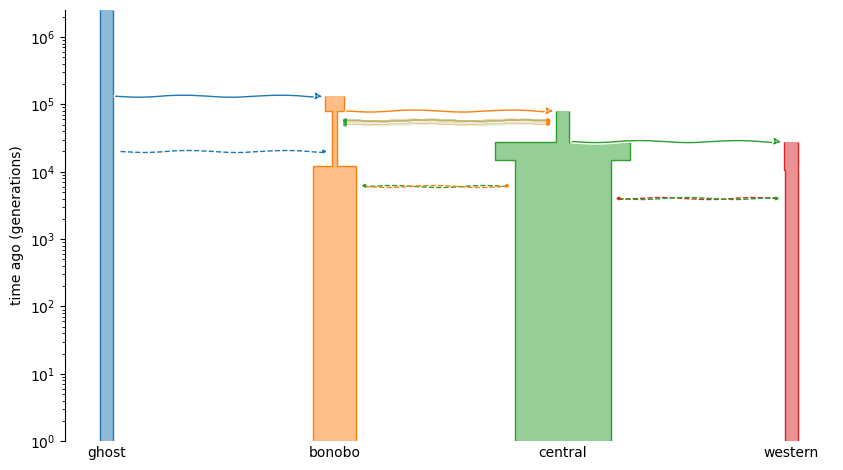

In [2]:
import stdpopsim
import demesdraw
import warnings

species = stdpopsim.get_species("PanTro")
model = species.get_demographic_model("BonoboGhost_4K19")

# Plot a demesdraw "tubes" view of the model
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    demesdraw.tubes(model.model.to_demes(), log_time=True)

The code below (which is rather long) runs two selective sweeps, one in the bonobo and one in the western populations, at different times, more recently than the population splits, and takes 10 samples from each of the extant populations. _You don't need to understand how it works_: we have left it in in case you are interested (as it involves recapitation).

In [49]:
import numpy as np
import msprime
import stdpopsim
import tskit

contig = species.get_contig("chr3", mutation_rate=model.mutation_rate)
sample_sizes = {"western": 10, "central": 10, "bonobo": 10}

L = 20e6  # Simulate 20 Mb
G = 4000  # A time ago in generations: we assume populations from time 0..G are isolated and of constant size

sweep_params = {
    "bonobo": {"position": L//3, "s": 0.05},
    "western": {"position": (2 * L)//3, "s": 0.1},
}

# Make independent populations, some with selective sweeps
independent_pop_ts = []
for name, pop in model.model.items():
    if name in sample_sizes:
        Ne = pop.initial_size
        demog = msprime.Demography()
        demog.add_population(name=name, initial_size=Ne)
        if name in sweep_params:
            p = 1 / (2 * Ne)
            freqs = {"start_frequency": p, "end_frequency": 1 - p, "dt": 1 / (40 * Ne)}
            sweep_model = msprime.SweepGenicSelection(**freqs, **sweep_params[name])
            models = (sweep_model, msprime.StandardCoalescent())
        else:
            models = msprime.StandardCoalescent()
        independent_pop_ts.append(msprime.sim_ancestry(
            sample_sizes[name],
            model=models,
            demography=demog,
            recombination_rate=contig.recombination_map.slice(right=L, trim=True),
            sequence_length=L,
            end_time=G,
            random_seed=1
        ))
combined_ts = independent_pop_ts[0]
for ts in independent_pop_ts[1:]:
    combined_ts = combined_ts.union(ts, node_mapping=np.full(ts.num_nodes, tskit.NULL))

# Now recapitate: initial_state uses the population names in the combined_ts to figure out which are which
ts = msprime.sim_mutations(
    msprime.sim_ancestry(initial_state=combined_ts, demography=model.model, random_seed=123).simplify(),
    rate=model.mutation_rate,
    random_seed=123,
)
print(f"Simulated a complex demography: {final_ts.num_sites} sites for {final_ts.num_samples} genomes")

Simulated a complex demography: 191861 sites for 60 genomes


# Edge plots


<dl class="exercise"><dt>Exercise 1</dt>
<dd>Use the <code>ARG_workshop.edge_plot</code> function to plot the spans and parent times of the edges in the simulated tree sequence. Add the <code>plot_hist=True</code> argument to show a weighted histogram on the right of the plot. You can make it wider using the <code>width</code> argument
</dl>

In [54]:
# Exercise 1: plot the edges along the genome


In [ ]:
# Execute code block with <shift>+Return to display question; type and press return, or click on the buttons to answer
workbook.question("edge_plot")

To illustrate the dependence on sample size, we can create the same plot with a fraction of the number of samples. This is likely to remove recent coalescence events with a far higher probability than removing older ones. As a result, information about the recent selective sweep in bonobos is mostly lost.

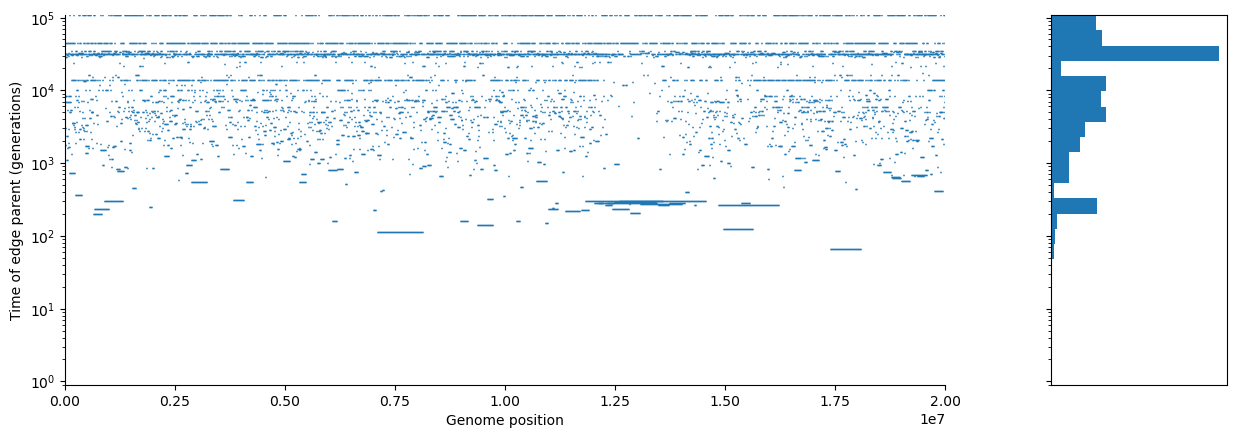

In [53]:
ARG_workshop.edge_plot(ts.simplify(ts.samples()[np.array([0, 1, 3, 20, 21, 22, 30, 31, 32])]), width=15, plot_hist=True)

If our dataset is split up into different populations, we can plot those separately, which can be telling. Note, however, that our example is an extreme case, in which the 3 populations have radically different selective histories, with no migration or admixture since the selection events, so the pattern is much clearer than most real examples.

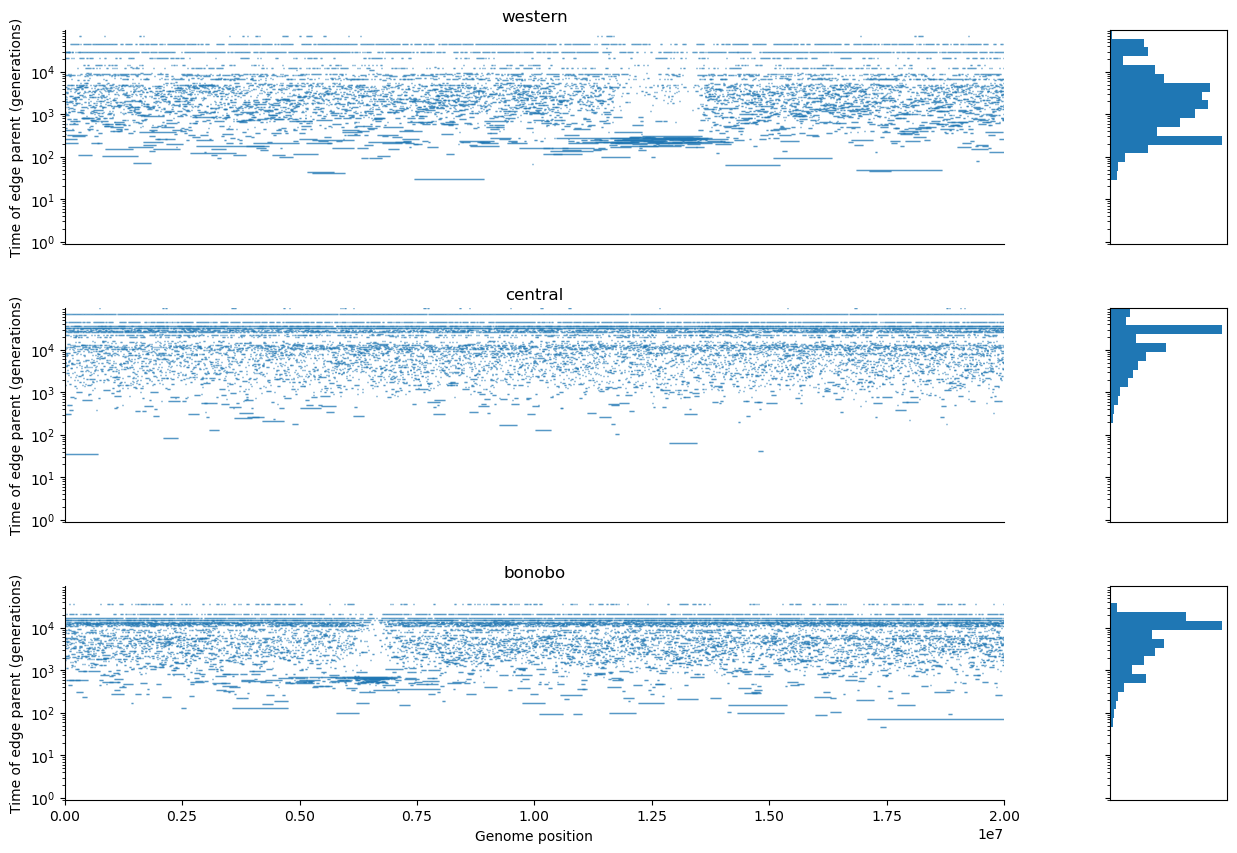

In [39]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(3, 2, gridspec_kw={"width_ratios": [8, 1], "hspace": 0.3}, figsize=(15, 10), sharey=True)
for ax_row, pop in zip(axes, ts.populations()):
    xaxis = (pop.id==ts.population(-1).id)
    ARG_workshop.edge_plot(ts.simplify(ts.samples(population=pop.id)), ax=ax_row, xaxis=xaxis, title=pop.metadata["name"], alpha=0.5)

# Coalescent rates heatmap

As we previously saw, another visualization is to bin the instantaneous coalescence rate into time and genome windows, weighted by the pairwise each event is associated with a random pair of genomes. However, binning means that the resolution is poorer, and bins are subject to differences in the amount of expected variation.

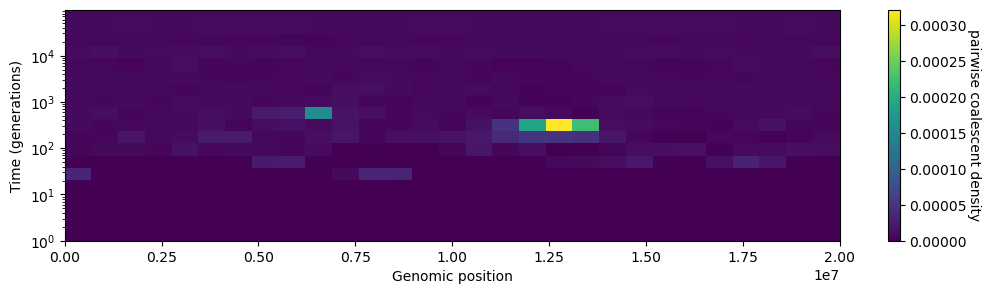

In [36]:
def pair_coalescence_rates(ts, time_breaks=None, window_breaks=None):
    # NB: in the next tskit release (0.5.9), there will be an API change such that
    # this function will be directly available as `ts.pair_coalescence_rates(time_breaks)`
    d = ts.coalescence_time_distribution(window_breaks=window_breaks, weight_func="pair_coalescence_events")
    return d.coalescence_rate_in_intervals(np.array(time_breaks))

def plot_pair_rates(ts, genomic_windows, num_log_timebins, ax=None):
    time_breaks = np.logspace(0, np.log10(ts.max_time), num_log_timebins)
    rates = pair_coalescence_rates(ts, window_breaks=genomic_windows, time_breaks=time_breaks)
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(12.5, 3))
    im = ax.pcolormesh(genomic_windows, time_breaks, rates[0])
    ax.set_yscale("log")
    bar = plt.colorbar(im, ax=ax)
    bar.ax.set_ylabel('pairwise coalescent density', labelpad=10, rotation=270)

genomic_windows = np.linspace(0, final_ts.sequence_length, 30)
plot_pair_rates(ts.simplify(), genomic_windows, num_log_timebins=20)
plt.xlabel("Genome position")
plt.ylabel(f"Time ({ts.time_units})");

In [ ]:
# Execute code block with <shift>+Return to display question; type and press return, or click on the buttons to answer
workbook.question("heatmap")

Again, we can break this down into populations

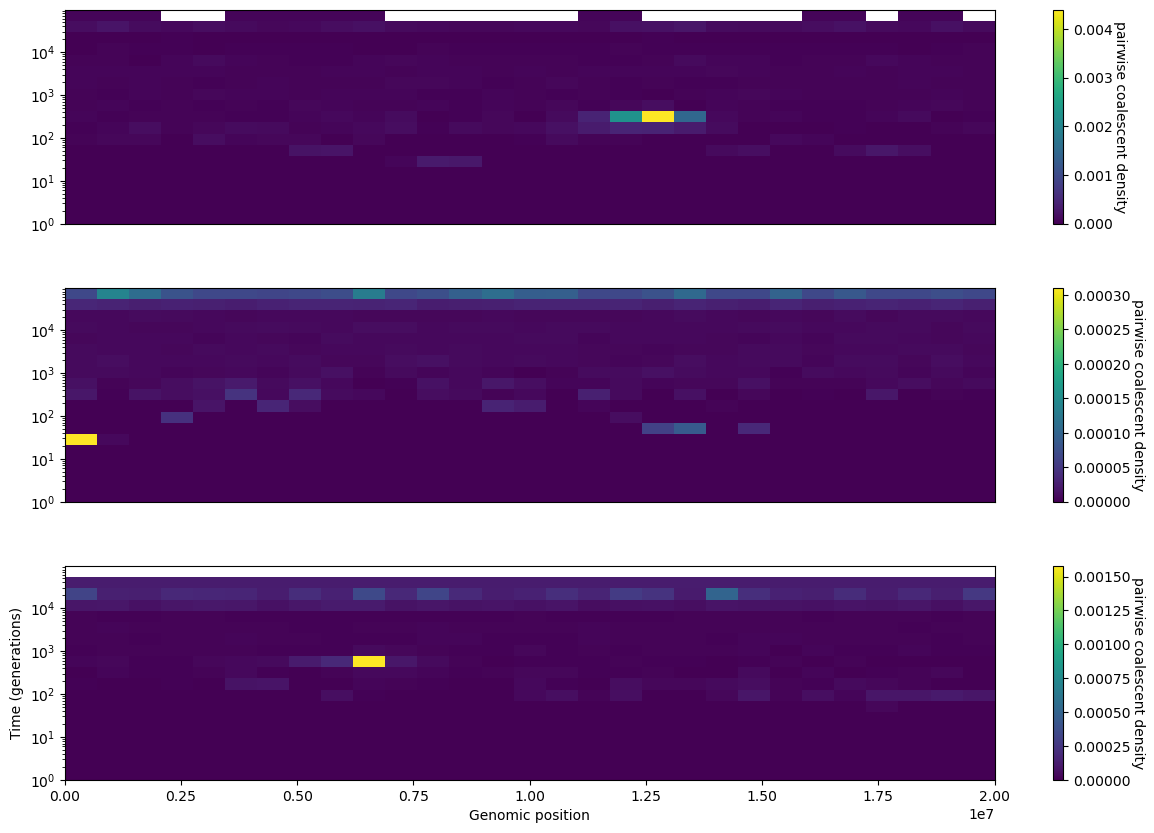

In [37]:
fig, axes = plt.subplots(3, 1, gridspec_kw={"hspace": 0.3}, figsize=(15, 10), sharey=True)
for ax, pop in zip(axes, ts.populations()):
    plot_pair_rates(ts.simplify(ts.samples(population=pop.id)), genomic_windows, num_log_timebins=20, ax=ax)
    ax.set_title=pop.metadata["name"]
    ax.set_ylabel(f"Time ({ts.time_units})");
    if pop.id==ts.population(-1).id:
        ax.set_xlabel("Genome position")
    else:
        ax.set_xticks([])

### Cross coalescence rates

### Topological analysis

#### GNN

The genealogical_nearest_neighbours statistic was introduced

ts.genealogical_nearest_neighbours

In [ ]:
# With just the topology, you can look at the GNN, or count the types of topology:
ts.genealogical_nearest_neighbours